## Import Packages

In [9]:
#importing some useful packages
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


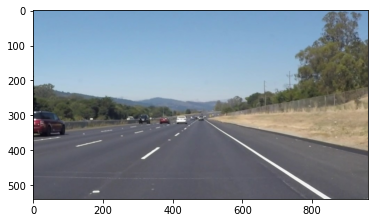

In [10]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

In [11]:
def show_img(img, name='image', cmap='gray'):
    if img.ndim > 3:
        cmap = None
    if cmap is None:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap=cmap)
    plt.title(name)
    plt.show()


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def compute_lin_reg(left):
    from scipy import stats
    x = left[:, 0]
    y = left[:, 1]
    cmin, cmax = min(x), max(x)

    # pfit, stats =np.Polynomial.fit(x, y, 1, full=True, window=(cmin, cmax), domain=(cmin, cmax))
    # m,b = np.polyfit(x, y, 1, full=True, window=(cmin, cmax), domain=(cmin, cmax))
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return gradient, intercept


def get_points(left, m, c, y_min = 340, y_max = 540):
    x_min = int((y_min-c)/m)
    x_max = int((y_max-c)/m)
    # x_min = min(left[:, 0])
    # x_max = max(left[:, 0])
    # y_min = int(x_min * m + c)
    # y_max = int(x_max * m + c)
    return (x_min, y_min), (x_max, y_max)


def compute_pts(left, y_min=340, y_max=540):
    m, c = compute_lin_reg(left)
    p1, p2 = get_points(left, m, c)
    return p1, p2


def draw_lines(img, lines, color=[255, 0, 0], thickness=12, y_min=300, y_max=540):
    line_arr = np.array([lines[i][0] for i in range(lines.shape[0])])
    left = []
    right = []
    for x1, y1, x2, y2 in line_arr:
        cur_m = (y2 - y1) / (x2 - x1)
        if cur_m < 0.0 and cur_m > -math.inf:
            left.append([x1, y1])
            left.append([x2, y2])
        if cur_m > 0.0 and cur_m < math.inf:
            right.append([x1, y1])
            right.append([x2, y2])
    assert (len(left) > 1)
    assert (len(right) > 1)
    left = np.array(left)
    right = np.array(right)
    p1, p2 = compute_pts(left)
    cv2.line(img, p1, p2, color, thickness)
    p1, p2 = compute_pts(right)
    cv2.line(img, p1, p2, color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, y_min=300, y_max=540):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, y_min=340, y_max=540)
    return line_img


# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Build a Lane Finding Pipeline



In [12]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
def draw(image):
#     image = mpimg.imread(path)
    gray_img = grayscale(image)
    gblur_img = gaussian_blur(gray_img, 3)
    can_img = canny(gblur_img, 50, 150)
    y_min = 300
    y_max = 540
    vertices = np.array([[[490, 300], [450, 300], [40, 540], [910, 540]]], dtype=np.int32)
    reg_img = region_of_interest(can_img, vertices)
    hou_img = hough_lines(reg_img, 1, math.pi / 180, 50, 30, 15)
    w_img = weighted_img(image, hou_img)
    return w_img


In [13]:
# path = "test_images/solidYellowCurve.jpg" 
# image = plt.imread(path)
# gray_img = grayscale(image)
# gblur_img = gaussian_blur(gray_img, 3)
# can_img = canny(gblur_img, 50, 150)
# y_min = 300
# y_max = 540
# vertices = np.array([[[490, 300], [450, 300], [50, 540], [910, 540]]], dtype=np.int32)
# reg_img = region_of_interest(can_img, vertices)
# hou_img = hough_lines(reg_img, 1, math.pi / 180, 50, 25, 20)
# show_img(hou_img)

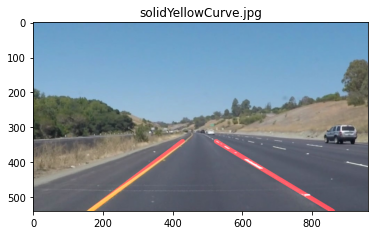

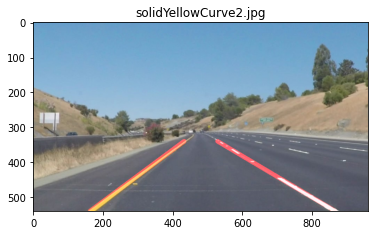

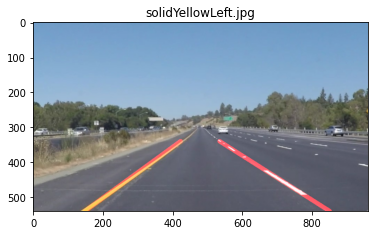

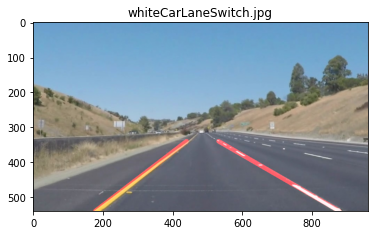

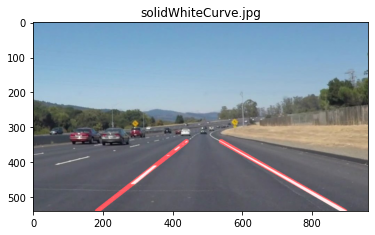

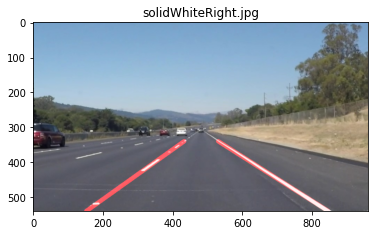

In [14]:
test_fold = "test_images/" 
out_img_fold = 'test_images_output/'
os.listdir(test_fold)
for item in os.listdir(test_fold):
    path = test_fold+item
    image = mpimg.imread(path)
    proc_img = draw(image)
    show_img(proc_img, name = item)
    plt.imsave(out_img_fold+item, proc_img)
    
    

In [15]:
# imageio.plugins.ffmpeg.download()

## Test on Videos

In [16]:

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:
def process_image(image):
    result = draw(image)
    return result

In [18]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   9%|▊         | 19/221 [00:00<00:01, 182.20it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 5.18 s, sys: 153 ms, total: 5.33 s
Wall time: 2.06 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [20]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   0%|          | 0/681 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 18.3 s, sys: 853 ms, total: 19.2 s
Wall time: 6.62 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission



## Optional Challenge



In [22]:
challenge_output = 'test_videos_output/challenge.mp4'
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   0%|          | 0/251 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 10.7 s, sys: 415 ms, total: 11.1 s
Wall time: 5.32 s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))